In [2]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl
from uncertainties import unumpy as up

In [3]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [9]:
def pos(x,pos):
    for i in range(len(pos)):
        if pos[i]>=x:
            return i
            break

In [6]:
def gaus1fit(von,bis,path,x,y,err,yscale,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 

            
    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]), out_gaus


In [7]:
fig = plt.figure(figsize=(20,10),dpi=80,linewidth=50)
data = [[]]
err = [[],[],[]]
for i in range(len(os.listdir('Data'))):
    path = 'Data/'+os.listdir('Data')[i]
    print(path)
    with open(path) as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        if len(dataex[3])==151:
            data[0] = dataex[3]
        elif len(dataex[3])==101:
            data[1] = dataex[3]
        elif len(dataex[3])==201:
            data[2] = dataex[3] 
        else:
            print('Error')
        
        data.append(dataex[4])
        err[0],err[1],err[2]=[0],[0],[0]
        err.append(dataex[4]*0.05)



Data/Deltam -0%.csv
Data/Deltam -10%.csv
Data/Deltam -100%.csv
Data/Deltam -100%V2.csv
Data/Deltam -20%.csv
Data/Deltam -30%.csv
Data/Deltam -40%.csv
Data/Deltam -50%.csv
Data/Deltam -60%.csv
Data/Deltam -70%.csv
Data/Deltam -80%.csv
Data/Deltam -90%.csv
Data/Deltam 10%.csv
Data/Deltam 100%.csv
Data/Deltam 20%.csv
Data/Deltam 30%.csv
Data/Deltam 40%.csv
Data/Deltam 50%.csv
Data/Deltam 60%.csv
Data/Deltam 70%.csv
Data/Deltam 80%.csv
Data/Deltam 90%.csv


<Figure size 1600x800 with 0 Axes>

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 88
    # variables        = 3
    chi-square         = 1422957.71
    reduced chi-square = 16740.6789
    Akaike info crit   = 858.800198
    Bayesian info crit = 866.232209
[[Variables]]
    amplitude:  7.6608e-07 +/- 1.3762e-08 (1.80%) (init = 1.0421e-06)
    center:     27.7110015 +/- 0.00474531 (0.02%) (init = 27.74)
    sigma:      0.40605211 +/- 0.00364056 (0.90%) (init = 0.58)
    fwhm:       0.95617963 +/- 0.00857286 (0.90%) == '2.3548200*sigma'
    height:     7.5267e-07 +/- 1.8568e-08 (2.47%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = 0.751
    C(amplitude, sigma)  = -0.638
    C(center, sigma)     = -0.449


(array([[2.70000000e+01, 2.70100000e+01, 2.70200000e+01, 2.70300000e+01,
         2.70400000e+01, 2.70500000e+01, 2.70600000e+01, 2.70700000e+01,
         2.70800000e+01, 2.70900000e+01, 2.71000000e+01, 2.71100000e+01,
         2.71200000e+01, 2.71300000e+01, 2.71400000e+01, 2.71500000e+01,
         2.71600000e+01, 2.71700000e+01, 2.71800000e+01, 2.71900000e+01,
         2.72000000e+01, 2.72100000e+01, 2.72200000e+01, 2.72300000e+01,
         2.72400000e+01, 2.72500000e+01, 2.72600000e+01, 2.72700000e+01,
         2.72800000e+01, 2.72900000e+01, 2.73000000e+01, 2.73100000e+01,
         2.73200000e+01, 2.73300000e+01, 2.73400000e+01, 2.73500000e+01,
         2.73600000e+01, 2.73700000e+01, 2.73800000e+01, 2.73900000e+01,
         2.74000000e+01, 2.74100000e+01, 2.74200000e+01, 2.74300000e+01,
         2.74400000e+01, 2.74500000e+01, 2.74600000e+01, 2.74700000e+01,
         2.74800000e+01, 2.74900000e+01, 2.75000000e+01, 2.75100000e+01,
         2.75200000e+01, 2.75300000e+01, 2.75400000

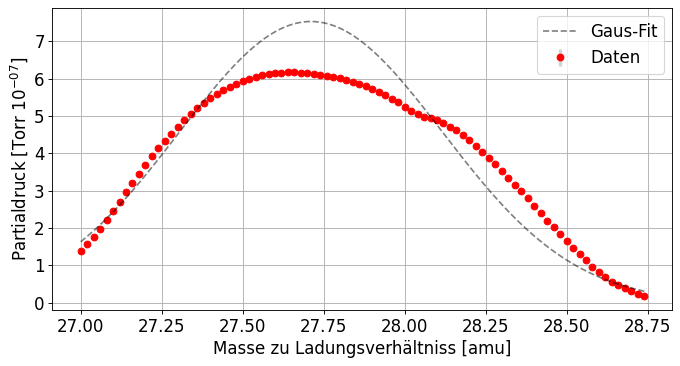

In [17]:
gaus1fit(27,28.75,'0%',data[0],data[3],err[3],1e7)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 55
    # variables        = 3
    chi-square         = 4133.05630
    reduced chi-square = 79.4818520
    Akaike info crit   = 243.569159
    Bayesian info crit = 249.591158
[[Variables]]
    amplitude:  1.5242e-07 +/- 4.1217e-09 (2.70%) (init = 2.154552e-07)
    center:     27.9759745 +/- 0.00546001 (0.02%) (init = 28.02)
    sigma:      0.24448430 +/- 0.00372786 (1.52%) (init = 0.32)
    fwhm:       0.57571653 +/- 0.00877843 (1.52%) == '2.3548200*sigma'
    height:     2.4872e-07 +/- 9.1521e-09 (3.68%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.593
    C(amplitude, sigma)  = -0.473
    C(amplitude, center) = 0.333


(array([[2.75000000e+01, 2.75100000e+01, 2.75200000e+01, 2.75300000e+01,
         2.75400000e+01, 2.75500000e+01, 2.75600000e+01, 2.75700000e+01,
         2.75800000e+01, 2.75900000e+01, 2.76000000e+01, 2.76100000e+01,
         2.76200000e+01, 2.76300000e+01, 2.76400000e+01, 2.76500000e+01,
         2.76600000e+01, 2.76700000e+01, 2.76800000e+01, 2.76900000e+01,
         2.77000000e+01, 2.77100000e+01, 2.77200000e+01, 2.77300000e+01,
         2.77400000e+01, 2.77500000e+01, 2.77600000e+01, 2.77700000e+01,
         2.77800000e+01, 2.77900000e+01, 2.78000000e+01, 2.78100000e+01,
         2.78200000e+01, 2.78300000e+01, 2.78400000e+01, 2.78500000e+01,
         2.78600000e+01, 2.78700000e+01, 2.78800000e+01, 2.78900000e+01,
         2.79000000e+01, 2.79100000e+01, 2.79200000e+01, 2.79300000e+01,
         2.79400000e+01, 2.79500000e+01, 2.79600000e+01, 2.79700000e+01,
         2.79800000e+01, 2.79900000e+01, 2.80000000e+01, 2.80100000e+01,
         2.80200000e+01, 2.80300000e+01, 2.80400000

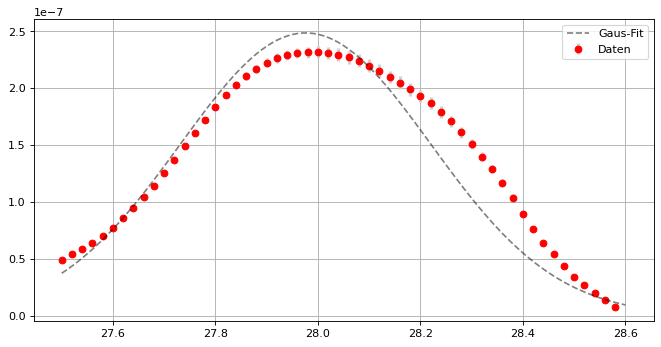

In [45]:
gaus1fit(27.5,28.6,'-10%',data[0],data[4],err[4])

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 65
    # variables        = 3
    chi-square         = 2758.37717
    reduced chi-square = 44.4899543
    Akaike info crit   = 249.620685
    Bayesian info crit = 256.143846
[[Variables]]
    amplitude:  2.1230e-07 +/- 4.0790e-09 (1.92%) (init = 2.936438e-07)
    center:     27.9326495 +/- 0.00315900 (0.01%) (init = 27.97)
    sigma:      0.27855101 +/- 0.00244171 (0.88%) (init = 0.35)
    fwhm:       0.65593748 +/- 0.00574978 (0.88%) == '2.3548200*sigma'
    height:     3.0406e-07 +/- 7.6386e-09 (2.51%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.550
    C(amplitude, center) = 0.534
    C(center, sigma)     = -0.152


(array([[2.73000000e+01, 2.73100000e+01, 2.73200000e+01, 2.73300000e+01,
         2.73400000e+01, 2.73500000e+01, 2.73600000e+01, 2.73700000e+01,
         2.73800000e+01, 2.73900000e+01, 2.74000000e+01, 2.74100000e+01,
         2.74200000e+01, 2.74300000e+01, 2.74400000e+01, 2.74500000e+01,
         2.74600000e+01, 2.74700000e+01, 2.74800000e+01, 2.74900000e+01,
         2.75000000e+01, 2.75100000e+01, 2.75200000e+01, 2.75300000e+01,
         2.75400000e+01, 2.75500000e+01, 2.75600000e+01, 2.75700000e+01,
         2.75800000e+01, 2.75900000e+01, 2.76000000e+01, 2.76100000e+01,
         2.76200000e+01, 2.76300000e+01, 2.76400000e+01, 2.76500000e+01,
         2.76600000e+01, 2.76700000e+01, 2.76800000e+01, 2.76900000e+01,
         2.77000000e+01, 2.77100000e+01, 2.77200000e+01, 2.77300000e+01,
         2.77400000e+01, 2.77500000e+01, 2.77600000e+01, 2.77700000e+01,
         2.77800000e+01, 2.77900000e+01, 2.78000000e+01, 2.78100000e+01,
         2.78200000e+01, 2.78300000e+01, 2.78400000

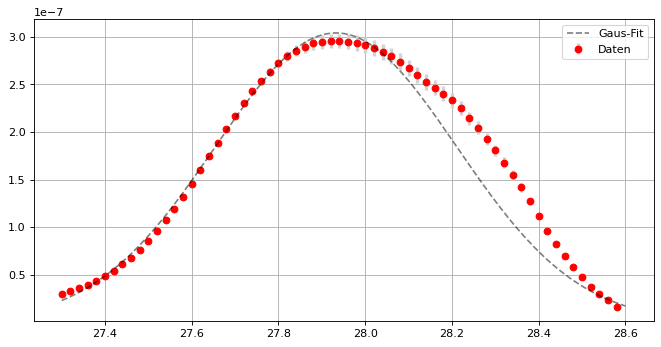

In [48]:
gaus1fit(27.3,28.6,'-20%',data[0],data[5],err[5])

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 70
    # variables        = 3
    chi-square         = 1304.53365
    reduced chi-square = 19.4706514
    Akaike info crit   = 210.757396
    Bayesian info crit = 217.502881
[[Variables]]
    amplitude:  2.5264e-07 +/- 4.8318e-09 (1.91%) (init = 3.234241e-07)
    center:     27.9421076 +/- 0.00310117 (0.01%) (init = 27.96)
    sigma:      0.28588376 +/- 0.00250291 (0.88%) (init = 0.36)
    fwhm:       0.67320480 +/- 0.00589390 (0.88%) == '2.3548200*sigma'
    height:     3.5255e-07 +/- 8.8406e-09 (2.51%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.557
    C(amplitude, center) = 0.207
    C(center, sigma)     = -0.122


(array([[2.72000000e+01, 2.72100000e+01, 2.72200000e+01, 2.72300000e+01,
         2.72400000e+01, 2.72500000e+01, 2.72600000e+01, 2.72700000e+01,
         2.72800000e+01, 2.72900000e+01, 2.73000000e+01, 2.73100000e+01,
         2.73200000e+01, 2.73300000e+01, 2.73400000e+01, 2.73500000e+01,
         2.73600000e+01, 2.73700000e+01, 2.73800000e+01, 2.73900000e+01,
         2.74000000e+01, 2.74100000e+01, 2.74200000e+01, 2.74300000e+01,
         2.74400000e+01, 2.74500000e+01, 2.74600000e+01, 2.74700000e+01,
         2.74800000e+01, 2.74900000e+01, 2.75000000e+01, 2.75100000e+01,
         2.75200000e+01, 2.75300000e+01, 2.75400000e+01, 2.75500000e+01,
         2.75600000e+01, 2.75700000e+01, 2.75800000e+01, 2.75900000e+01,
         2.76000000e+01, 2.76100000e+01, 2.76200000e+01, 2.76300000e+01,
         2.76400000e+01, 2.76500000e+01, 2.76600000e+01, 2.76700000e+01,
         2.76800000e+01, 2.76900000e+01, 2.77000000e+01, 2.77100000e+01,
         2.77200000e+01, 2.77300000e+01, 2.77400000

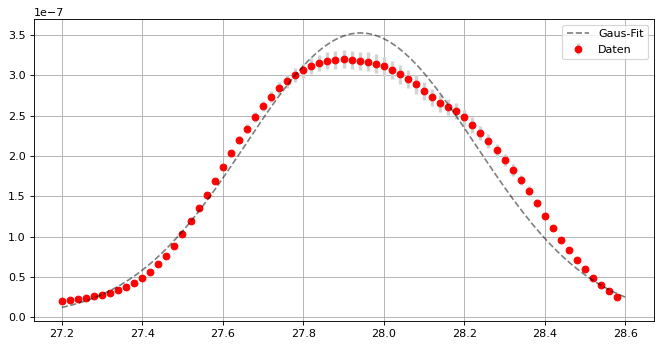

In [52]:
gaus1fit(27.2,28.6,'-30%',data[0],data[6],err[6])

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 75
    # variables        = 3
    chi-square         = 1127.19127
    reduced chi-square = 15.6554343
    Akaike info crit   = 209.249708
    Bayesian info crit = 216.202172
[[Variables]]
    amplitude:  3.0571e-07 +/- 5.8753e-09 (1.92%) (init = 4.095322e-07)
    center:     27.9212263 +/- 0.00346991 (0.01%) (init = 27.93)
    sigma:      0.31083136 +/- 0.00285094 (0.92%) (init = 0.41)
    fwhm:       0.73195189 +/- 0.00671346 (0.92%) == '2.3548200*sigma'
    height:     3.9237e-07 +/- 9.9299e-09 (2.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.530
    C(center, sigma)     = 0.170
    C(amplitude, center) = 0.133


(array([[2.71000000e+01, 2.71100000e+01, 2.71200000e+01, 2.71300000e+01,
         2.71400000e+01, 2.71500000e+01, 2.71600000e+01, 2.71700000e+01,
         2.71800000e+01, 2.71900000e+01, 2.72000000e+01, 2.72100000e+01,
         2.72200000e+01, 2.72300000e+01, 2.72400000e+01, 2.72500000e+01,
         2.72600000e+01, 2.72700000e+01, 2.72800000e+01, 2.72900000e+01,
         2.73000000e+01, 2.73100000e+01, 2.73200000e+01, 2.73300000e+01,
         2.73400000e+01, 2.73500000e+01, 2.73600000e+01, 2.73700000e+01,
         2.73800000e+01, 2.73900000e+01, 2.74000000e+01, 2.74100000e+01,
         2.74200000e+01, 2.74300000e+01, 2.74400000e+01, 2.74500000e+01,
         2.74600000e+01, 2.74700000e+01, 2.74800000e+01, 2.74900000e+01,
         2.75000000e+01, 2.75100000e+01, 2.75200000e+01, 2.75300000e+01,
         2.75400000e+01, 2.75500000e+01, 2.75600000e+01, 2.75700000e+01,
         2.75800000e+01, 2.75900000e+01, 2.76000000e+01, 2.76100000e+01,
         2.76200000e+01, 2.76300000e+01, 2.76400000

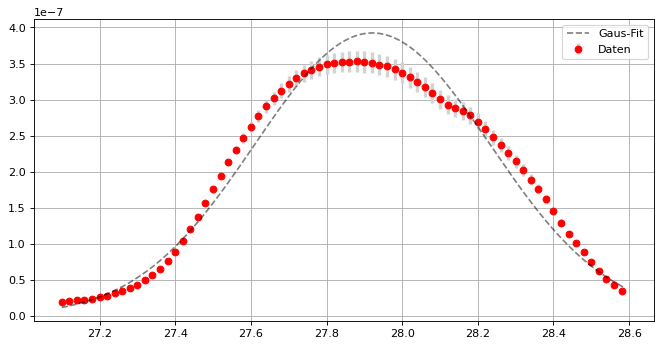

In [57]:
gaus1fit(27.1,28.6,'-40%',data[0],data[7],err[7])